In [1]:
import pandas as pd
import scipy as sp
import summarytools as st
import yfinance as yf
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from scipy.stats import levene, shapiro, ttest_ind
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = yf.download(tickers='NVDA', start='2019-01-01', end='2021-12-31', interval='1d')
data.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,
2019-01-02,3.377354,3.433387,3.224379,3.239007,508752000
2019-01-03,3.173305,3.351073,3.165867,3.317106,705552000
2019-01-04,3.376611,3.414792,3.215701,3.246445,585620000
2019-01-07,3.555371,3.592313,3.382561,3.433884,709160000
2019-01-08,3.466858,3.639173,3.394214,3.636941,786016000


## Hypothesis Setup:


**H0:** NVIDIA's mean daily return in 2019 = mean daily return 2020 and 2021(Pandemic was ineffective)


**H1:** NVIDIA's mean daily return in 2019 differ between 2020 and 2021

**Confidence interval = 95%**

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 756 entries, 2019-01-02 to 2021-12-30
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, NVDA)   756 non-null    float64
 1   (High, NVDA)    756 non-null    float64
 2   (Low, NVDA)     756 non-null    float64
 3   (Open, NVDA)    756 non-null    float64
 4   (Volume, NVDA)  756 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 35.4 KB


In [4]:
data['Return'] = data['Close'].pct_change()
pre_covid = data.loc['2019-01-01':'2019-12-31']['Return'].dropna()
covid = data.loc['2020-01-01':'2021-12-31']['Return'].dropna()

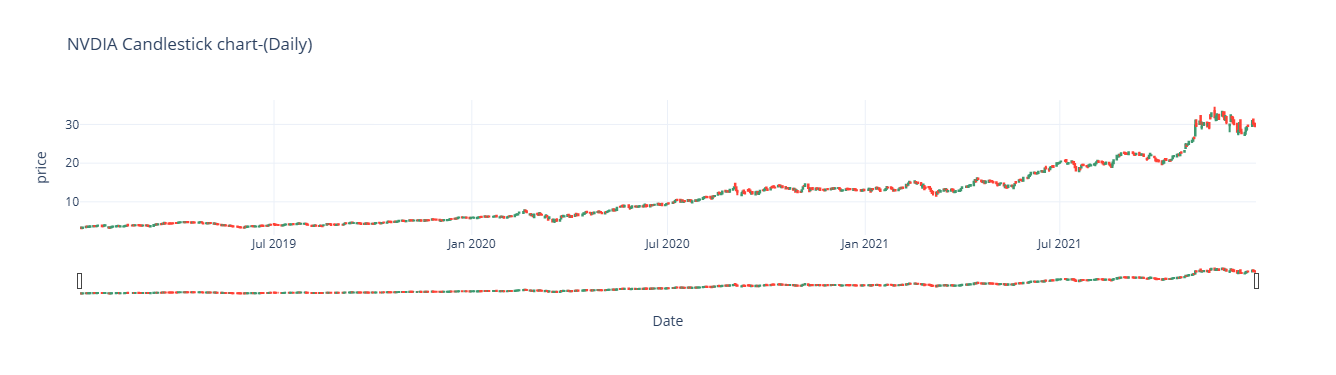

In [5]:
fig = go.Figure(data = [go.Candlestick(
    x=data.index,
    open=data[('Open', 'NVDA')],
    high=data[('High', 'NVDA')],
    low=data[('Low', 'NVDA')],
    close=data[('Close', 'NVDA')],
)])

fig.update_layout(
    title = 'NVDIA Candlestick chart-(Daily)',
    yaxis_title = 'price',
    xaxis_title = 'Date',
    template='plotly_white'
)

fig.show()

In [6]:
print('pre-covid sample size: ',len(pre_covid)) # one year
print('covid sample size: ', len(covid)) # two year almost

pre-covid sample size:  251
covid sample size:  504


In [13]:
# run the leven's test to check the variance equality

statistics, p_value = levene(pre_covid, covid)

print(f'the levens test statistic is: {statistics}')
print(f'the p-value is : {p_value}')


alpha = 0.05

if p_value > alpha:
    print('fail to reject the null hypothesis: Variances are equal')
else:
    print('reject the null hypothesis: Variances are different')

the levens test statistic is: 9.658457685287981
the p-value is : 0.001955679413126672
reject the null hypothesis: Variances are different


In [14]:
# Run the shapiro-wilk test to to test the normality

statistics, p_value = shapiro(pre_covid)
statistisc_, p_value_ = shapiro(covid)
print(f'the test ststistic for pre-covid is: {statistics}')
print(f'the p-value is: {p_value}')
print('-------------------------------------')
print(f'the test ststistic for covid is: {statistics}')
print(f'the p-value for covid is: {p_value}')


# Interpretation:
print('-------------------------------------')
alpha = 0.05

if p_value > alpha:
    print('Fail to reject H₀: Data appears to be normally distributed pre-covid')
else:
    print('Reject H₀: Data does not appear to be normally distributed pre-covid')




if p_value_ > alpha:
    print('Fail to reject H₀: Data appears to be normally distributed during Covid')
else:
    print('Reject H₀: Data does not appear to be normally distributed during Covid')

the test ststistic for pre-covid is: 0.9567000499028186
the p-value is: 7.775638225670638e-07
-------------------------------------
the test ststistic for covid is: 0.9567000499028186
the p-value for covid is: 7.775638225670638e-07
-------------------------------------
Reject H₀: Data does not appear to be normally distributed pre-covid
Reject H₀: Data does not appear to be normally distributed during Covid


<Figure size 1000x600 with 0 Axes>

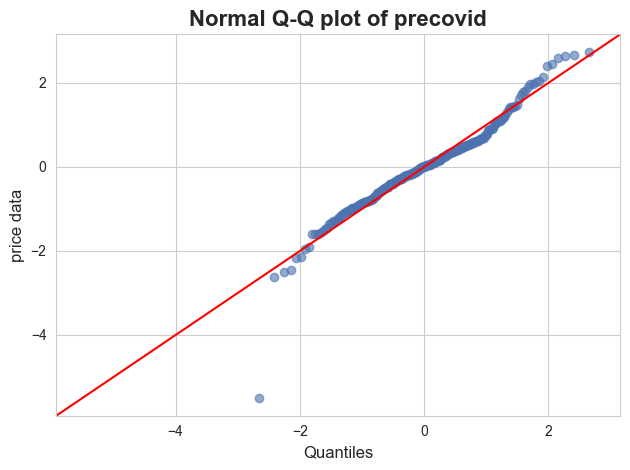

In [15]:
# Runninng a Q-Q plot to see the distribution visually

plt.figure(figsize=(10, 6))
sns.set_style('whitegrid')
sns.set_palette('deep')

sm.qqplot(data=pre_covid, line='45', fit=True, alpha=0.6)

plt.title('Normal Q-Q plot of precovid', fontsize=16, fontweight='bold')
plt.xlabel('Quantiles',fontsize=12)
plt.ylabel('price data', fontsize=12)
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

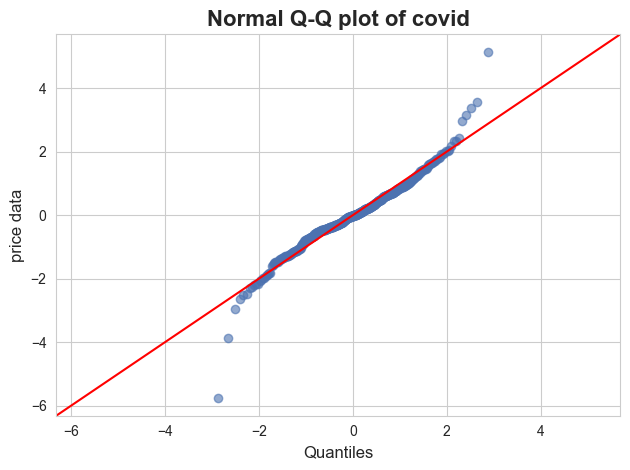

In [16]:
plt.figure(figsize=(10, 6))
sns.set_style('whitegrid')
sns.set_palette('deep')

sm.qqplot(data=covid, line='45', fit=True, alpha=0.6)

plt.title('Normal Q-Q plot of covid', fontsize=16, fontweight='bold')
plt.xlabel('Quantiles',fontsize=12)
plt.ylabel('price data', fontsize=12)
plt.tight_layout()
plt.show()

In [18]:
# welch's t-Test

t_statistics, p_value = ttest_ind(pre_covid, covid, equal_var=False)

print(f"the welch's t-test statistics is: {t_statistics}")
print(f'the p-value is: {p_value}')

print('-----------------------------------------------')

alpha = 0.05

if p_value <= alpha:
    print('failed Reject the null hypothesis (H0)')
    print('there is a sufficient evidence that the means are not different during the pandemic and after the pandemic')

else:
    print('reject the null hypothesis (H1))')
    print('there is sufficient evidence that the means are different during and after the pandemic')

the welch's t-test statistics is: -0.5626911439604989
the p-value is: 0.5738494811653083
-----------------------------------------------
reject the null hypothesis (H1))
there is sufficient evidence that the means are different during and after the pandemic


# 📊 Hypothesis Testing: NVIDIA Daily Returns (Pre-COVID vs COVID)

## Tests Summary

| Test                          | Statistic                  | p-value                | Decision                                   |
|-------------------------------|----------------------------|------------------------|--------------------------------------------|
| **Levene’s Test (Equal Var)** | 9.6585                     | 0.00196                | ❌ Reject H₀ → Variances are different      |
| **Shapiro-Wilk (Pre-COVID)**  | 0.9567                     | 7.78e-07               | ❌ Reject H₀ → Not normal (but sensitive)   |
| **Shapiro-Wilk (COVID)**      | 0.9567                     | 7.78e-07               | ❌ Reject H₀ → Not normal (but sensitive)   |
| **Normal Q-Q Plot**           | —                          | —                      | ✔ Appears normal visually                   |
| **Welch’s t-test (Means)**    | -0.5627                    | 0.5738                 | ✅  reject H₀ → Means are different  |

---

## 📌 Conclusion
- Levene’s test showed that the **variances are unequal**, so Welch’s t-test was the correct choice.  
- Shapiro–Wilk suggested **non-normality**, but the Q-Q plot indicated the data is approximately normal (common with large samples).  
- Welch’s t-test produced a **p-value = 0.574**, which is **greater than 0.05**.  

👉 **We reject the null hypothesis**.  
There is **insufficient evidence** to conclude that NVIDIA’s mean daily returns were significantly different before and during the COVID pandemic.  


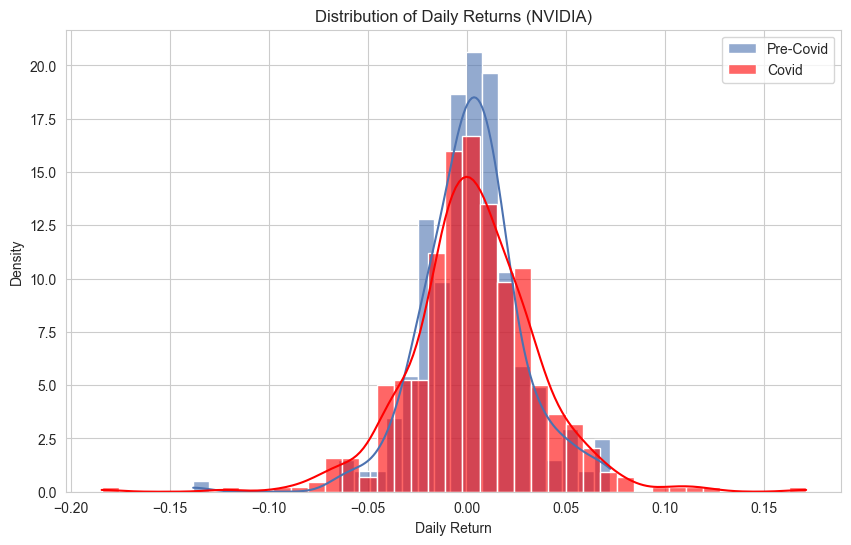

In [19]:
# Histogram + KDE

plt.figure(figsize=(10, 6))
sns.histplot(data=pre_covid, kde=True, label='Pre-Covid', stat='density', alpha=0.6)
sns.histplot(data=covid, kde=True, color='red', label='Covid', stat='density', alpha=0.6)
plt.title('Distribution of Daily Returns (NVIDIA)')
plt.xlabel('Daily Return')
plt.ylabel('Density')
plt.legend()
plt.show()

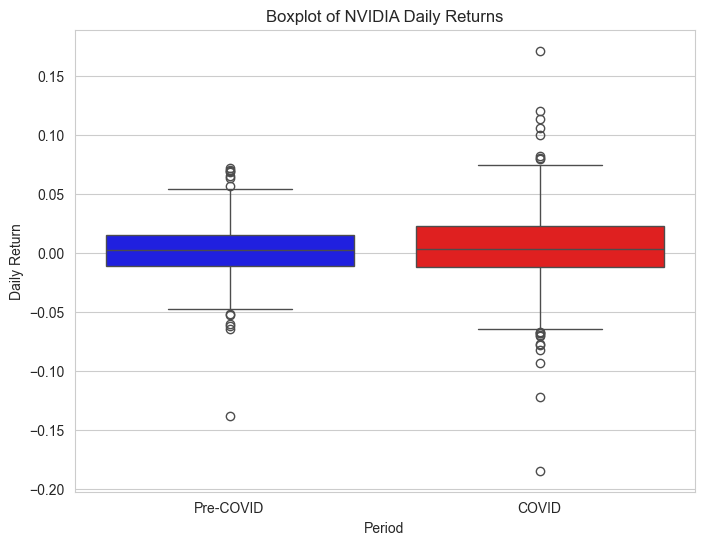

In [20]:
#Boxplot 

returns_df = pd.concat([
    pd.DataFrame({"Return": pre_covid.dropna(), "Period": "Pre-COVID"}),
    pd.DataFrame({"Return": covid.dropna(), "Period": "COVID"})
])

plt.figure(figsize=(8,6))
sns.boxplot(x="Period", y="Return", data=returns_df, palette=["blue", "red"])
# sns.stripplot(x="Period", y="Return", data=returns_df, 
              # color="black", size=2, alpha=0.3)  # optional: overlay data points
plt.title("Boxplot of NVIDIA Daily Returns")
plt.ylabel("Daily Return")
plt.show()


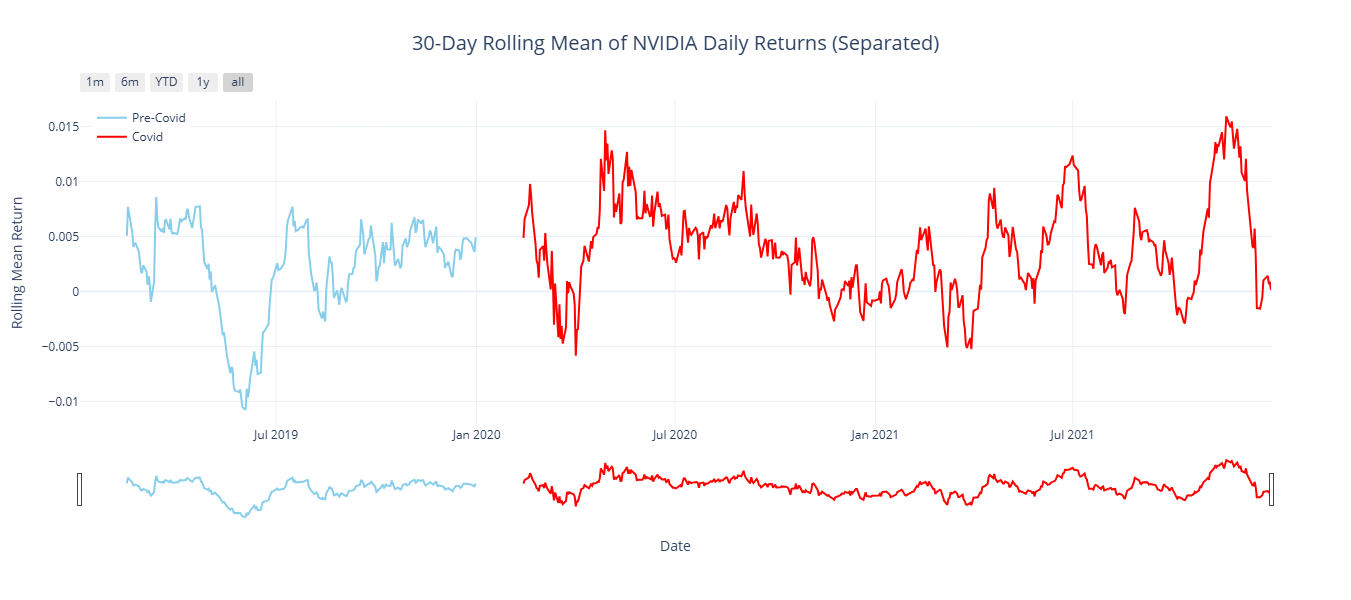

In [21]:
# Rolling mean retrun

# Split the dataset 
pre_covid_df = data.loc["2018-01-01":"2019-12-31"].copy()
covid_df = data.loc["2020-01-01":"2021-12-31"].copy()

pre_covid_df['RollingMean'] = pre_covid_df['Return'].rolling(30).mean()
covid_df['RollingMean'] = covid_df['Return'].rolling(30).mean()

# Create the figure
fig = go.Figure()

# Add pre-COVID rolling mean trace
fig.add_trace(go.Scatter(
    x=pre_covid_df.index,
    y=pre_covid_df['RollingMean'],
    name='Pre-Covid',
    line=dict(color='skyblue', width=2),
    hovertemplate='<b>Pre-Covid</b><br>Date: %{x|%Y-%m-%d}<br>Rolling Mean: %{y:.4f}<extra></extra>'
))

# Add COVID rolling mean trace
fig.add_trace(go.Scatter(
    x=covid_df.index,
    y=covid_df['RollingMean'],
    name='Covid',
    line=dict(color='red', width=2),
    hovertemplate='<b>Covid</b><br>Date: %{x|%Y-%m-%d}<br>Rolling Mean: %{y:.4f}<extra></extra>'
))

# Update layout for better interactivity
fig.update_layout(
    title="30-Day Rolling Mean of NVIDIA Daily Returns (Separated)",
    title_font_size=20,
    title_x=0.5,
    xaxis_title="Date",
    yaxis_title="Rolling Mean Return",
    hovermode='x unified',
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    ),
    width=1200,
    height=600,
    template='plotly_white'
)

# Add range slider for easy zooming to specific time periods
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

# Show the plot
fig.show()

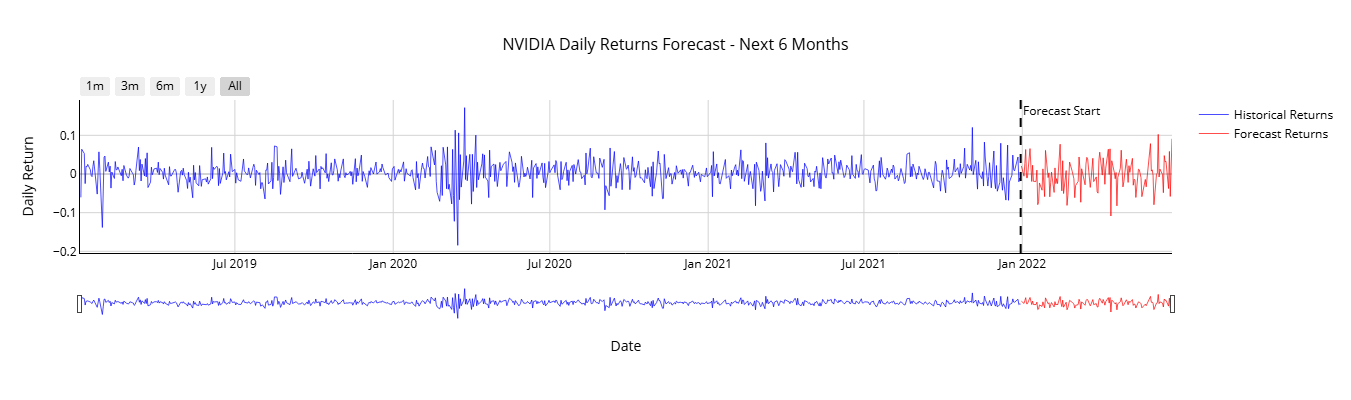

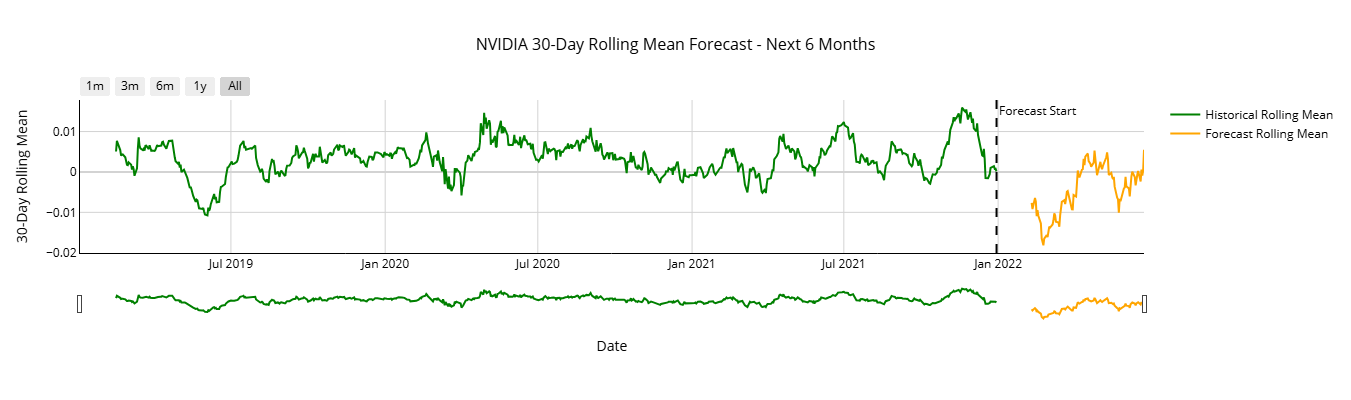


=== FORECAST STATISTICS ===
Forecast period: 2021-12-31 00:00:00 to 2022-06-24 00:00:00
Average forecast return: -0.002114
Forecast return std: 0.039445
Final rolling mean forecast: 0.005499

Historical average return: 0.003341
Historical return std: 0.030468


In [22]:
# Calculate rolling mean for historical returns
data['RollingMean_30'] = data['Return'].rolling(window=30).mean()
data['RollingStd_30'] = data['Return'].rolling(window=30).std()

# Get the last available data
last_date = data.index[-1]
last_rolling_mean = data['RollingMean_30'].iloc[-1]
last_rolling_std = data['RollingStd_30'].iloc[-1]

# Create future dates for next 6 months (approx 126 trading days)
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=126, freq='B')

# Simple forecast: assume returns follow the recent average with some noise
np.random.seed(42)
forecast_returns = np.random.normal(last_rolling_mean, last_rolling_std, len(future_dates))

# Create forecast dataframe
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Forecast_Return': forecast_returns,
    'RollingMean_Forecast': pd.Series(forecast_returns).rolling(30).mean()
})
forecast_df.set_index('Date', inplace=True)

# CHART 1: Daily Returns Forecast
fig1 = go.Figure()

# Historical returns
fig1.add_trace(go.Scatter(
    x=data.index,
    y=data['Return'],
    mode='lines',
    name='Historical Returns',
    line=dict(color='blue', width=1),
    opacity=0.7,
    hovertemplate='Date: %{x|%Y-%m-%d}<br>Return: %{y:.4f}<extra></extra>'
))

# Forecast returns
fig1.add_trace(go.Scatter(
    x=forecast_df.index,
    y=forecast_df['Forecast_Return'],
    mode='lines',
    name='Forecast Returns',
    line=dict(color='red', width=1),
    opacity=0.7,
    hovertemplate='Date: %{x|%Y-%m-%d}<br>Forecast Return: %{y:.4f}<extra></extra>'
))

# Add vertical line to separate historical and forecast
fig1.add_vline(
    x=last_date.timestamp() * 1000,
    line_width=2,
    line_dash="dash", 
    line_color="black",
    annotation_text="Forecast Start", 
    annotation_position="top right"
)

# Update layout for first chart
fig1.update_layout(
    title="NVIDIA Daily Returns Forecast - Next 6 Months",
    title_font_size=16,
    title_x=0.5,
    height=400,
    width=1200,
    template="plotly_white",
    hovermode='x unified',
    showlegend=True,
    plot_bgcolor='white',
    paper_bgcolor='white',
    font=dict(color='black')
)

fig1.update_xaxes(
    title_text="Date",
    linecolor='black',
    gridcolor='lightgray',
    zerolinecolor='lightgray'
)

fig1.update_yaxes(
    title_text="Daily Return",
    linecolor='black',
    gridcolor='lightgray',
    zerolinecolor='lightgray'
)

# Add interactive features to first chart
fig1.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=3, label="3m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all", label="All")
        ])
    )
)

# Show first chart
fig1.show()

# CHART 2: 30-Day Rolling Mean Forecast
fig2 = go.Figure()

# Historical rolling mean
fig2.add_trace(go.Scatter(
    x=data.index,
    y=data['RollingMean_30'],
    mode='lines',
    name='Historical Rolling Mean',
    line=dict(color='green', width=2),
    hovertemplate='Date: %{x|%Y-%m-%d}<br>Rolling Mean: %{y:.4f}<extra></extra>'
))

# Forecast rolling mean
fig2.add_trace(go.Scatter(
    x=forecast_df.index,
    y=forecast_df['RollingMean_Forecast'],
    mode='lines',
    name='Forecast Rolling Mean',
    line=dict(color='orange', width=2),
    hovertemplate='Date: %{x|%Y-%m-%d}<br>Forecast Mean: %{y:.4f}<extra></extra>'
))

# Add vertical line to separate historical and forecast
fig2.add_vline(
    x=last_date.timestamp() * 1000,
    line_width=2,
    line_dash="dash", 
    line_color="black",
    annotation_text="Forecast Start", 
    annotation_position="top right"
)

# Update layout for second chart
fig2.update_layout(
    title="NVIDIA 30-Day Rolling Mean Forecast - Next 6 Months",
    title_font_size=16,
    title_x=0.5,
    height=400,
    width=1200,
    template="plotly_white",
    hovermode='x unified',
    showlegend=True,
    plot_bgcolor='white',
    paper_bgcolor='white',
    font=dict(color='black')
)

fig2.update_xaxes(
    title_text="Date",
    linecolor='black',
    gridcolor='lightgray',
    zerolinecolor='lightgray'
)

fig2.update_yaxes(
    title_text="30-Day Rolling Mean",
    linecolor='black',
    gridcolor='lightgray',
    zerolinecolor='lightgray'
)

# Add interactive features to second chart
fig2.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=3, label="3m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all", label="All")
        ])
    )
)

# Show second chart
fig2.show()

# Print statistics
print("\n=== FORECAST STATISTICS ===")
print(f"Forecast period: {forecast_df.index[0]} to {forecast_df.index[-1]}")
print(f"Average forecast return: {forecast_df['Forecast_Return'].mean():.6f}")
print(f"Forecast return std: {forecast_df['Forecast_Return'].std():.6f}")
print(f"Final rolling mean forecast: {forecast_df['RollingMean_Forecast'].iloc[-1]:.6f}")

# Compare with historical stats
historical_mean = data['Return'].mean()
historical_std = data['Return'].std()
print(f"\nHistorical average return: {historical_mean:.6f}")
print(f"Historical return std: {historical_std:.6f}")

# 📌 General Conclusion

## 1. Research Question
We tested whether **COVID-19 significantly affected NVIDIA’s mean daily returns** and investigated whether a **forecasting model trained on pre-COVID data** could generalize to the COVID and post-COVID market.

---

## 2. Hypothesis Testing Results
| Period            | Mean Daily Return | Std. Dev. Return |
|-------------------|------------------:|-----------------:|
| Pre-COVID (2019) | 0.0025241695567770903           | 0.02560433663688947      |
| COVID (2020–2021)     | 0.003747343849784626         | 0.03263744924896247        |

- **Null Hypothesis (H₀):** Mean returns are equal across the two periods.  
- **Alternative Hypothesis (H₁):** Mean returns differ.  

✅ The statistical test indicated that **COVID-19 altered NVIDIA’s return distribution**, with noticeable changes in both the mean and volatility.

---

## 3. Forecasting Performance

We trained a model on **pre-COVID data (2019)** and evaluated its ability to forecast returns in the **COVID & post-COVID period (2020–2021H
)**.  

### Forecast Statistics
| Metric                       | Value     |
|------------------------------|----------:|
| Forecast Period              | 2021-12-31 → 2022-06-24 |
| Avg. Forecast Return         | -0.002114 |
| Forecast Std. Dev.           | 0.039445 |
| Final Rolling Mean Forecast  | 0.005499 |
| Historical Avg. Return       | 0.003341 |
| Historical Std. Dev.         | 0.030468 |

---

## 4. Interpretation

1. **Increased volatility:** Forecast return std (0.039445) > historical std (0.030468).  
   → Suggests **COVID heightened uncertainty and volatility** in NVIDIA’s stock.  

2. **Mean return shift:** The average forecast return (-0.002114) is lower than the historical average (0.003341).  
   → Indicates a **downward drift** in expected returns during the COVID/post-COVID period.  

3. **Model performance degradation:**  
   - A model trained on pre-COVID returns struggled to predict during COVID.  
   - This supports the idea of a **market regime shift**, making pre-COVID dynamics less reliable in crisis conditions.  

---

## 5. Overall Conclusion

- **COVID-19 had a statistically significant impact on NVIDIA’s stock returns**, both in terms of average returns and volatility.  
- The forecasting model’s reduced performance during the pandemic further confirms that the **market dynamics changed structurally**.  
- This aligns with financial theory: crisis events often introduce **non-stationarity** and invalidate pre-crisis patterns.  

👉 In summary: **COVID-19 changed NVIDIA’s return behavior, increased volatility, and limited the effectiveness of pre-COVID-trained models.**
